In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv


####    Using this dataset, I'm going to forecast a stock price. The purpose is to prediction if I buy a share of a stock in current price, what will be the price of it in a year. I'll select the stock under 200USD, which are Apple, Tesla, Google, Amazon with a hypothesis that I have 200 USD to invest at this moment.


### **The analysis will have the process below:**

##### **First,** I'm going to select one stock under 200USD per share by anlayzing trend and seasonlity.

##### **Second,** I'm going to apply this selected stock to Prophet model.

##### **Third,** find best parameter to get more precise forecast.

##### **Last,** Compare the price of current and forecast.

### Set the library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression


# Load the Data

In [3]:
#Load data
df = pd.read_csv('/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv')
df.head()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,0,2/2/2024,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650,...,"5,89,498",10580,564.64,4030000,171.81,117220000,474.99,84710000,"2,053.70",NaN
1,1,1/2/2024,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690,...,"5,81,600",9780,567.51,3150000,159.28,66360000,394.78,25140000,"2,071.10",260920.0
2,2,31-01-2024,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480,...,"5,78,020",9720,564.11,4830000,155.20,49690000,390.14,20010000,"2,067.40",238370.0
3,3,30-01-2024,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130,...,"5,84,680",9750,562.85,6120000,159.00,42290000,400.06,18610000,"2,050.90",214590.0
4,4,29-01-2024,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230,...,"5,78,800",13850,575.79,6880000,161.26,42840000,401.02,17790000,"2,034.90",1780.0


As there are only 2 data for Feburary of 2024, I think it would be better to delete this rows.

In [4]:
df = df.drop(labels=[0,1], axis=0)
df.head()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
2,2,31-01-2024,2.100,142860.0,75.85,344490.0,3.906,NaN,"42,580.50",56480,...,"5,78,020",9720,564.11,4830000,155.20,49690000,390.14,20010000,"2,067.40",238370.0
3,3,30-01-2024,2.077,139750.0,77.82,347240.0,3.911,NaN,"42,946.20",55130,...,"5,84,680",9750,562.85,6120000,159.00,42290000,400.06,18610000,"2,050.90",214590.0
4,4,29-01-2024,2.490,3590.0,76.78,331930.0,3.879,NaN,"43,299.80",45230,...,"5,78,800",13850,575.79,6880000,161.26,42840000,401.02,17790000,"2,034.90",1780.0
5,5,26-01-2024,2.712,73020.0,78.01,365460.0,3.852,NaN,"41,811.30",69470,...,"5,82,300",10040,570.42,12770000,159.12,51050000,394.14,13160000,"2,026.60",410.0
6,6,25-01-2024,2.571,44980.0,77.36,320180.0,3.869,NaN,"39,935.70",46300,...,"5,76,211",9350,562.00,9450000,157.75,43310000,393.18,15090000,"2,027.10",460.0


# Feature Engineeering

In [5]:
#Set Datetime
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'],format = '%d-%m-%Y')

In [6]:
#add the date of weekends as we have only weekday data
df.set_index('Date', inplace=True)
df_1 = df.reindex(pd.date_range(df.index.min(), df.index.max())).sort_index(ascending=False).reset_index().rename(columns={'index': 'Date'})
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1491 non-null   datetime64[ns]
 1   Unnamed: 0         1011 non-null   float64       
 2   Natural_Gas_Price  1011 non-null   float64       
 3   Natural_Gas_Vol.   1008 non-null   float64       
 4   Crude_oil_Price    1011 non-null   float64       
 5   Crude_oil_Vol.     989 non-null    float64       
 6   Copper_Price       1011 non-null   float64       
 7   Copper_Vol.        976 non-null    float64       
 8   Bitcoin_Price      1011 non-null   object        
 9   Bitcoin_Vol.       1011 non-null   float64       
 10  Platinum_Price     1011 non-null   object        
 11  Platinum_Vol.      636 non-null    float64       
 12  Ethereum_Price     1011 non-null   object        
 13  Ethereum_Vol.      1011 non-null   float64       
 14  S&P_500_

In [7]:
df_1 = df_1.sort_values('Date', ascending=True)
df_1 = df_1.reset_index(drop=True)
df_1

,Date,Unnamed: 0,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,2020-01-02,1012.0,2.122,164570.0,61.18,486870.0,2.825,72460.0,"6,967.00",632780.0,...,"3,42,261",410.0,329.81,4350000.0,94.90,80720000.0,209.78,12090000.0,"1,528.10",270550.0
1,2020-01-03,1011.0,2.130,144670.0,63.05,885860.0,2.787,74750.0,"7,343.10",936290.0,...,"3,39,155",220.0,325.90,3800000.0,93.75,75330000.0,208.67,11200000.0,"1,552.40",436740.0
2,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-06,1010.0,2.135,154680.0,63.27,724240.0,2.790,59570.0,"7,759.10",786750.0,...,"3,40,210",280.0,335.83,5670000.0,95.14,81310000.0,212.60,17070000.0,"1,568.80",558970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,2024-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,2024-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488,2024-01-29,4.0,2.490,3590.0,76.78,331930.0,3.879,NaN,"43,299.80",45230.0,...,"5,78,800",13850.0,575.79,6880000.0,161.26,42840000.0,401.02,17790000.0,"2,034.90",1780.0
1489,2024-01-30,3.0,2.077,139750.0,77.82,347240.0,3.911,NaN,"42,946.20",55130.0,...,"5,84,680",9750.0,562.85,6120000.0,159.00,42290000.0,400.06,18610000.0,"2,050.90",214590.0


In [8]:
#month_year for monthly Trend
#weekday for weekly seasonality

#get the month of each date
df_1['month_year'] = df_1['Date'].dt.to_period('M')
#get the weekday of each date (0:Monday ~ 4: Friday)
df_1['weekday'] = df_1['Date'].dt.weekday

In [9]:
df_1.head()

,Date,Unnamed: 0,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.,month_year,weekday
0,2020-01-02,1012.0,2.122,164570.0,61.18,486870.0,2.825,72460.0,"6,967.00",632780.0,...,329.81,4350000.0,94.90,80720000.0,209.78,12090000.0,"1,528.10",270550.0,2020-01,3
1,2020-01-03,1011.0,2.130,144670.0,63.05,885860.0,2.787,74750.0,"7,343.10",936290.0,...,325.90,3800000.0,93.75,75330000.0,208.67,11200000.0,"1,552.40",436740.0,2020-01,4
2,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01,5
3,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01,6
4,2020-01-06,1010.0,2.135,154680.0,63.27,724240.0,2.790,59570.0,"7,759.10",786750.0,...,335.83,5670000.0,95.14,81310000.0,212.60,17070000.0,"1,568.80",558970.0,2020-01,0


In [10]:
#extract necessary columns only
Data_stock = df_1[['Date', 'Apple_Price','Tesla_Price', 'Google_Price','Amazon_Price', 'month_year','weekday']]
Data_stock

,Date,Apple_Price,Tesla_Price,Google_Price,Amazon_Price,month_year,weekday
0,2020-01-02,75.09,28.68,68.43,94.90,2020-01,3
1,2020-01-03,74.36,29.53,68.08,93.75,2020-01,4
2,2020-01-04,NaN,NaN,NaN,NaN,2020-01,5
3,2020-01-05,NaN,NaN,NaN,NaN,2020-01,6
4,2020-01-06,74.95,30.10,69.89,95.14,2020-01,0
...,...,...,...,...,...,...,...
1486,2024-01-27,NaN,NaN,NaN,NaN,2024-01,5
1487,2024-01-28,NaN,NaN,NaN,NaN,2024-01,6
1488,2024-01-29,191.73,190.93,153.51,161.26,2024-01,0
1489,2024-01-30,188.04,191.59,151.46,159.00,2024-01,1


The weekends data has NaN value as we created, so let's fill NaN with the vlaue of a day before.

In [11]:
Data_stock = Data_stock.ffill()
Data_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1491 non-null   datetime64[ns]
 1   Apple_Price   1491 non-null   float64       
 2   Tesla_Price   1491 non-null   float64       
 3   Google_Price  1491 non-null   float64       
 4   Amazon_Price  1491 non-null   float64       
 5   month_year    1491 non-null   period[M]     
 6   weekday       1491 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), period[M](1)
memory usage: 75.8 KB


# General Flow of Stock Price

Before starting to forecast, let's briefe look on the flow of the stock price.

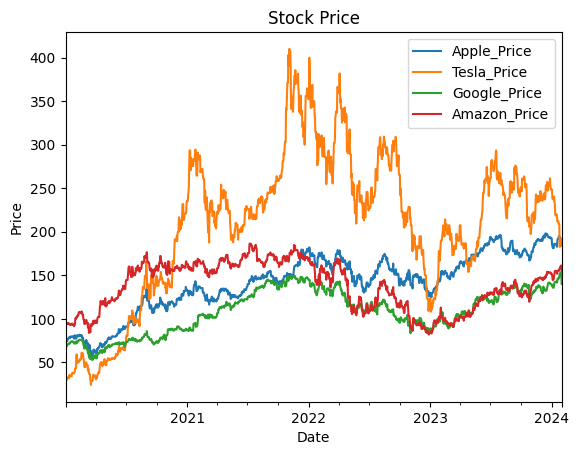

In [12]:
#show graph with three stocks price
Stock_month = Data_stock.loc[:,Data_stock.columns != 'weekday' ]
ax = Stock_month.plot(x="Date")
ax.set(title="Stock Price", ylabel="Price", xlabel="Date")
ax.grid
ax.legend()

**From the above chart**
- we can see the stock price of Tesla is the most fluctuative one.
- All of them had decreased trend from the end of 2021 to half of 2022
- However, they all turned to increase aroutn the start of 2023
- Moreover, the trend has increased from 2023 till now

Let's look into each stock price precisely with Trend and Seasonaliy analysis.

# Trend

### Daily Price Average Trend Forecast

In [13]:
Data_stock['Time'] = np.arange(len(Data_stock.index))
Data_stock

,Date,Apple_Price,Tesla_Price,Google_Price,Amazon_Price,month_year,weekday,Time
0,2020-01-02,75.09,28.68,68.43,94.90,2020-01,3,0
1,2020-01-03,74.36,29.53,68.08,93.75,2020-01,4,1
2,2020-01-04,74.36,29.53,68.08,93.75,2020-01,5,2
3,2020-01-05,74.36,29.53,68.08,93.75,2020-01,6,3
4,2020-01-06,74.95,30.10,69.89,95.14,2020-01,0,4
...,...,...,...,...,...,...,...,...
1486,2024-01-27,192.42,183.25,152.18,159.12,2024-01,5,1486
1487,2024-01-28,192.42,183.25,152.18,159.12,2024-01,6,1487
1488,2024-01-29,191.73,190.93,153.51,161.26,2024-01,0,1488
1489,2024-01-30,188.04,191.59,151.46,159.00,2024-01,1,1489


In [14]:
Stock_daily = Data_stock[['Apple_Price','Tesla_Price','Google_Price','Amazon_Price','Time']]

In [15]:
Stock_daily = Stock_daily.set_index('Time')

In [16]:
Stock_daily

,Apple_Price,Tesla_Price,Google_Price,Amazon_Price
Time,,,,
0,75.09,28.68,68.43,94.90
1,74.36,29.53,68.08,93.75
2,74.36,29.53,68.08,93.75
3,74.36,29.53,68.08,93.75
4,74.95,30.10,69.89,95.14
...,...,...,...,...
1486,192.42,183.25,152.18,159.12
1487,192.42,183.25,152.18,159.12
1488,191.73,190.93,153.51,161.26


In [17]:
Apple_daily = Data_stock.groupby('Time').mean()['Apple_Price']
Tesla_daily = Data_stock.groupby('Time').mean()['Tesla_Price']
Google_daily = Data_stock.groupby('Time').mean()['Google_Price']
Amazon_daily = Data_stock.groupby('Time').mean()['Amazon_Price']

let's check one dataset made above.

In [18]:
Apple_daily.info()

<class 'pandas.core.series.Series'>
Index: 1491 entries, 0 to 1490
Series name: Apple_Price
Non-Null Count  Dtype  
--------------  -----  
1491 non-null   float64
dtypes: float64(1)
memory usage: 23.3 KB


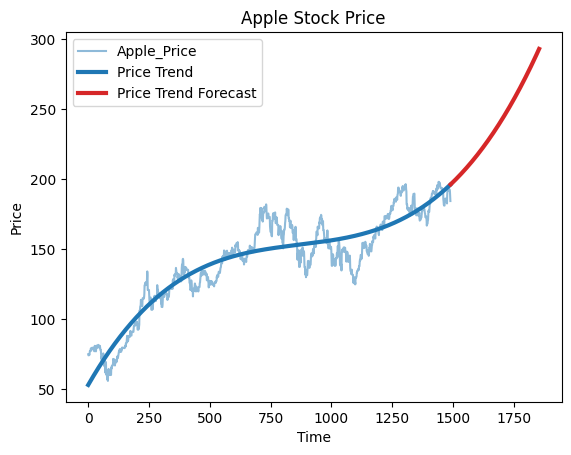

In [19]:
#create trend feature and forecasting
y_apple = Apple_daily.copy()  # the target

# Quadratic trend
dp = DeterministicProcess(
    order = 3,
    index = y_apple.index,)

#feature set
X_apple = dp.in_sample()

#feature for 365days forecast
X_apple_fore = dp.out_of_sample(steps=365)

#LinearRegression model
model = LinearRegression()
model.fit(X_apple, y_apple)

y_apple_pred = pd.Series(model.predict(X_apple), index=X_apple.index)
y_apple_fore = pd.Series(model.predict(X_apple_fore), index=X_apple_fore.index)

#Plot the graph of the model with prediction
ax = y_apple.plot(alpha=0.5, title="Apple Stock Price", ylabel="Price")
ax = y_apple_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_apple_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

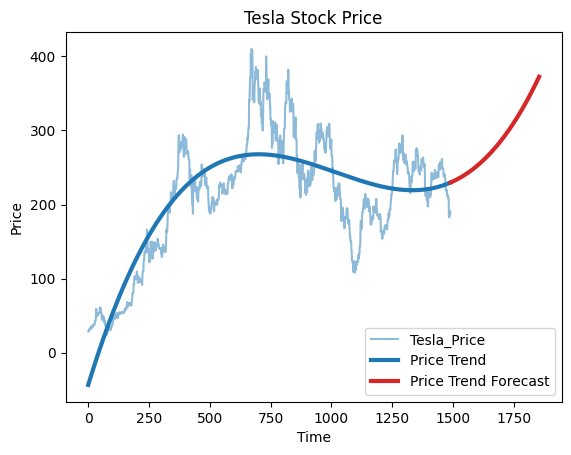

In [20]:
#create trend feature and forecasting
y_tesla = Tesla_daily.copy()  # the target

# Quadratic trend
dp = DeterministicProcess(
    order = 3,
    index = y_tesla.index,)

#feature set
X_tesla = dp.in_sample()

#feature for 365days forecast
X_tesla_fore = dp.out_of_sample(steps=365)

#LinearRegression model
model = LinearRegression()
model.fit(X_tesla, y_tesla)

y_tesla_pred = pd.Series(model.predict(X_tesla), index=X_tesla.index)
y_tesla_fore = pd.Series(model.predict(X_tesla_fore), index=X_tesla_fore.index)

#Plot the graph of the model with prediction
ax = y_tesla.plot(alpha=0.5, title="Tesla Stock Price", ylabel="Price")
ax = y_tesla_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_tesla_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

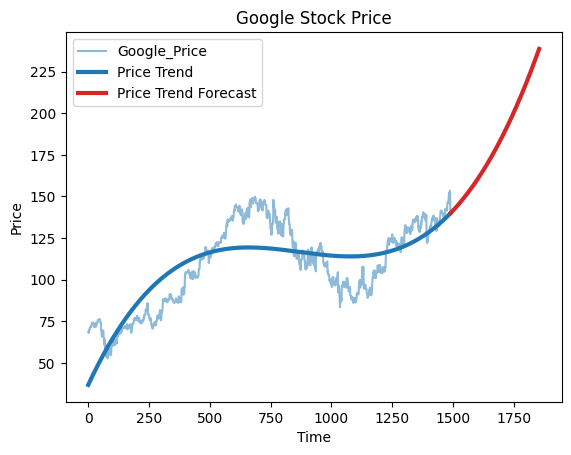

In [21]:
#create trend feature and forecasting
y_google = Google_daily.copy()  # the target

# Quadratic trend
dp = DeterministicProcess(
    order = 3,
    index = y_google.index,)

#feature set
X_google = dp.in_sample()

#feature for 365days forecast
X_google_fore = dp.out_of_sample(steps=365)

#LinearRegression model
model = LinearRegression()
model.fit(X_google, y_google)

y_google_pred = pd.Series(model.predict(X_google), index=X_google.index)
y_google_fore = pd.Series(model.predict(X_google_fore), index=X_google_fore.index)

#Plot the graph of the model with prediction
ax = y_google.plot(alpha=0.5, title="Google Stock Price", ylabel="Price")
ax = y_google_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_google_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

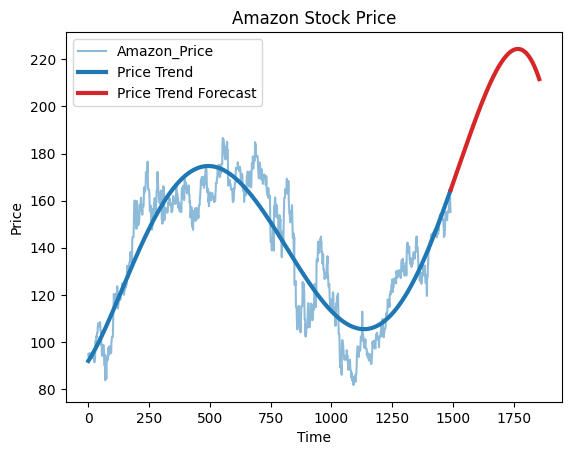

In [22]:
#create trend feature and forecasting
y_amazon = Amazon_daily.copy()  # the target

# Quadratic trend
dp = DeterministicProcess(
    order = 5,
    index = y_amazon.index,)

#feature set
X_amazon = dp.in_sample()

#feature for 365days forecast
X_amazon_fore = dp.out_of_sample(steps=365)

#LinearRegression model
model = LinearRegression()
model.fit(X_amazon, y_amazon)

y_amazon_pred = pd.Series(model.predict(X_amazon), index=X_amazon.index)
y_amazon_fore = pd.Series(model.predict(X_amazon_fore), index=X_amazon_fore.index)

#Plot the graph of the model with prediction
ax = y_amazon.plot(alpha=0.5, title="Amazon Stock Price", ylabel="Price")
ax = y_amazon_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_amazon_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

In [23]:
y_amazon_fore.tail

<bound method NDFrame.tail of 1491    164.664372
1492    164.956879
1493    165.249618
1494    165.542584
1495    165.835770
           ...    
1851    212.771040
1852    212.470890
1853    212.166376
1854    211.857479
1855    211.544177
Length: 365, dtype: float64>

In [24]:
y_amazon_fore.iloc[-1]

211.54417712949405

In [25]:
#Index: 1855 is the last day of 365 forecasted
print("Apple stock price in 365 later is:", y_apple_fore.iloc[-1])
print("Tesla stock price in 365 later is:", y_tesla_fore.iloc[-1])
print("Google stock price in 365 later is:", y_google_fore.iloc[-1])
print("Amazon stock price in 365 later is:", y_amazon_fore.iloc[-1])

Apple stock price in 365 later is: 292.9306097510207
Tesla stock price in 365 later is: 372.36149823142784
Google stock price in 365 later is: 238.69973710580882
Amazon stock price in 365 later is: 211.54417712949405


### Monthly Price Average Trend Forecast

In [26]:
Apple_monthly = Data_stock.groupby('month_year').mean()['Apple_Price']
Tesla_monthly = Data_stock.groupby('month_year').mean()['Tesla_Price']
Google_monthly = Data_stock.groupby('month_year').mean()['Google_Price']
Amazon_monthly = Data_stock.groupby('month_year').mean()['Amazon_Price']

let's check one dataset above:

In [27]:
Apple_monthly.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 49 entries, 2020-01 to 2024-01
Freq: M
Series name: Apple_Price
Non-Null Count  Dtype  
--------------  -----  
49 non-null     float64
dtypes: float64(1)
memory usage: 784.0 bytes


In [28]:
Apple_monthly.tail()

month_year
2023-09    177.853333
2023-10    174.477419
2023-11    186.006667
2023-12    194.228065
2024-01    187.832903
Freq: M, Name: Apple_Price, dtype: float64

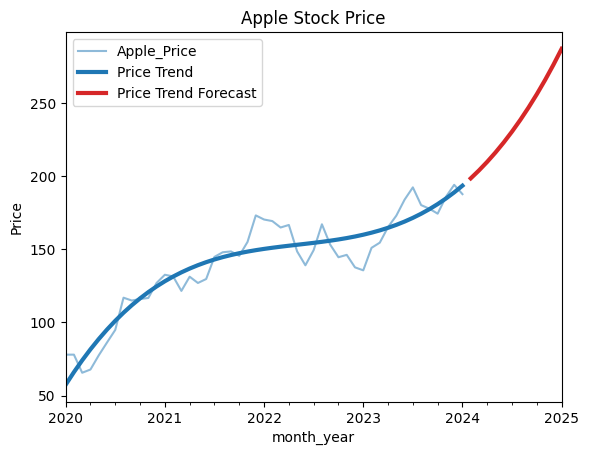

In [29]:
#create trend feature and forecasting
y_appleM = Apple_monthly.copy()  # the target

#try a few of orders
dp = DeterministicProcess(
    order = 3,
    index = y_appleM.index,)

#feature set
X_appleM = dp.in_sample()

#Feature for 12(12 months) forecast.
X_appleM_fore = dp.out_of_sample(steps=12)
model = LinearRegression()
model.fit(X_appleM, y_appleM)

y_appleM_pred = pd.Series(model.predict(X_appleM), index=X_appleM.index)
y_appleM_fore = pd.Series(model.predict(X_appleM_fore), index=X_appleM_fore.index)

#Plot the graph of the model with prediction
ax = y_appleM.plot(alpha=0.5, title="Apple Stock Price", ylabel="Price")
ax = y_appleM_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_appleM_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

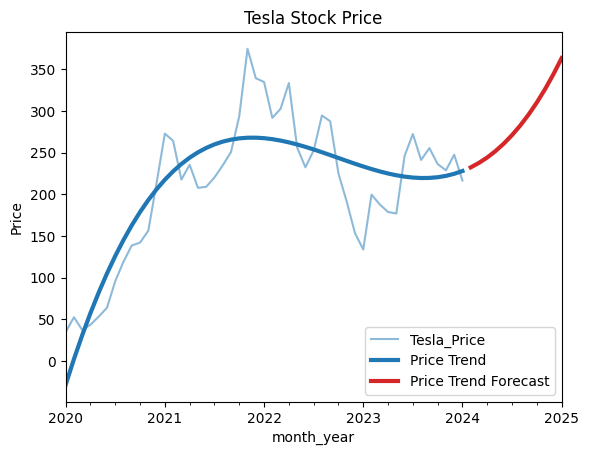

In [30]:
#create trend feature and forecasting
y_teslaM = Tesla_monthly.copy()  # the target

#try a few of orders
dp = DeterministicProcess(
    order = 3,
    index = y_teslaM.index,)

#feature set
X_teslaM = dp.in_sample()

#Feature for 12(12 months) forecast.
X_teslaM_fore = dp.out_of_sample(steps=12)
model = LinearRegression()
model.fit(X_teslaM, y_teslaM)

y_teslaM_pred = pd.Series(model.predict(X_teslaM), index=X_teslaM.index)
y_teslaM_fore = pd.Series(model.predict(X_teslaM_fore), index=X_teslaM_fore.index)

#Plot the graph of the model with prediction
ax = y_teslaM.plot(alpha=0.5, title="Tesla Stock Price", ylabel="Price")
ax = y_teslaM_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_teslaM_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

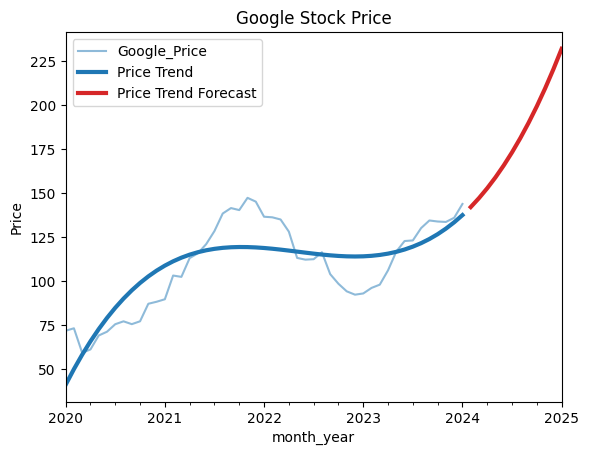

In [31]:
#create trend feature and forecasting
y_googleM = Google_monthly.copy()  # the target

#try a few of orders
dp = DeterministicProcess(
    order = 3,
    index = y_googleM.index,)

#feature set
X_googleM = dp.in_sample()

#Feature for 12(12 months) forecast.
X_googleM_fore = dp.out_of_sample(steps=12)
model = LinearRegression()
model.fit(X_googleM, y_googleM)

y_googleM_pred = pd.Series(model.predict(X_googleM), index=X_googleM.index)
y_googleM_fore = pd.Series(model.predict(X_googleM_fore), index=X_googleM_fore.index)

#Plot the graph of the model with prediction
ax = y_googleM.plot(alpha=0.5, title="Google Stock Price", ylabel="Price")
ax = y_googleM_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_googleM_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

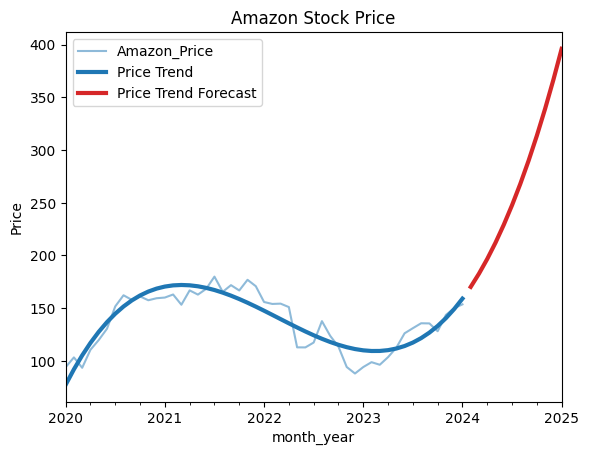

In [32]:
#create trend feature and forecasting
y_amazonM = Amazon_monthly.copy()  # the target

#try a few of orders
dp = DeterministicProcess(
    order = 3,
    index = y_amazonM.index,)

#feature set
X_amazonM = dp.in_sample()

#Feature for 12(12 months) forecast.
X_amazonM_fore = dp.out_of_sample(steps=12)
model = LinearRegression()
model.fit(X_amazonM, y_amazonM)

y_amazonM_pred = pd.Series(model.predict(X_amazonM), index=X_amazonM.index)
y_amazonM_fore = pd.Series(model.predict(X_amazonM_fore), index=X_amazonM_fore.index)

#Plot the graph of the model with prediction
ax = y_amazonM.plot(alpha=0.5, title="Amazon Stock Price", ylabel="Price")
ax = y_amazonM_pred.plot(ax=ax, linewidth=3, label="Price Trend", color='C0')
ax = y_amazonM_fore.plot(ax=ax, linewidth=3, label="Price Trend Forecast", color='C3')
ax.legend();

In [33]:
print("Apple stock price in 365 later is:", y_appleM_fore.iloc[-1])
print("Tesla stock price in 365 later is:", y_teslaM_fore.iloc[-1])
print("Google stock price in 365 later is:", y_googleM_fore.iloc[-1])
print("Amazon stock price in 365 later is:", y_amazonM_fore.iloc[-1])

Apple stock price in 365 later is: 287.3236278819446
Tesla stock price in 365 later is: 363.2680416959256
Google stock price in 365 later is: 231.7887719404477
Amazon stock price in 365 later is: 395.95314105050795


# Seasonality

I'd like to know if there's a seasonality by the day of week in stock price.\
So let's make the chart of average stock price by the day of week for each year.

In [34]:
Data_weekday = Data_stock[['Date', 'Apple_Price','Tesla_Price','Google_Price','Amazon_Price','weekday']]
Data_weekday

,Date,Apple_Price,Tesla_Price,Google_Price,Amazon_Price,weekday
0,2020-01-02,75.09,28.68,68.43,94.90,3
1,2020-01-03,74.36,29.53,68.08,93.75,4
2,2020-01-04,74.36,29.53,68.08,93.75,5
3,2020-01-05,74.36,29.53,68.08,93.75,6
4,2020-01-06,74.95,30.10,69.89,95.14,0
...,...,...,...,...,...,...
1486,2024-01-27,192.42,183.25,152.18,159.12,5
1487,2024-01-28,192.42,183.25,152.18,159.12,6
1488,2024-01-29,191.73,190.93,153.51,161.26,0
1489,2024-01-30,188.04,191.59,151.46,159.00,1


In [35]:
Data_weekday['year'] = Data_weekday['Date'].dt.isocalendar().year
Data_weekday

/tmp/ipykernel_18/2501124547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_weekday['year'] = Data_weekday['Date'].dt.isocalendar().year


,Date,Apple_Price,Tesla_Price,Google_Price,Amazon_Price,weekday,year
0,2020-01-02,75.09,28.68,68.43,94.90,3,2020
1,2020-01-03,74.36,29.53,68.08,93.75,4,2020
2,2020-01-04,74.36,29.53,68.08,93.75,5,2020
3,2020-01-05,74.36,29.53,68.08,93.75,6,2020
4,2020-01-06,74.95,30.10,69.89,95.14,0,2020
...,...,...,...,...,...,...,...
1486,2024-01-27,192.42,183.25,152.18,159.12,5,2024
1487,2024-01-28,192.42,183.25,152.18,159.12,6,2024
1488,2024-01-29,191.73,190.93,153.51,161.26,0,2024
1489,2024-01-30,188.04,191.59,151.46,159.00,1,2024


In [36]:
Apple_weekly = Data_weekday.loc[:,['Apple_Price','weekday','year']]
AW = Apple_weekly.groupby(['year','weekday']).mean()
AW = AW.reset_index()

Tesla_weekly = Data_weekday.loc[:,['Tesla_Price','weekday','year']]
TW = Tesla_weekly.groupby(['year','weekday']).mean()
TW = TW.reset_index()

Google_weekly = Data_weekday.loc[:,['Google_Price','weekday','year']]
GW = Google_weekly.groupby(['year','weekday']).mean()
GW = GW.reset_index()

Amazon_weekly = Data_weekday.loc[:,['Amazon_Price','weekday','year']]
AMW = Amazon_weekly.groupby(['year','weekday']).mean()
AMW = AMW.reset_index()

In [37]:
print(AW)
print(TW)
print(GW)
print(AMW)

    year  weekday  Apple_Price
0   2020        0    95.252115
1   2020        1    95.840769
2   2020        2    95.985962
3   2020        3    95.385849
4   2020        4    95.192453
5   2020        5    95.192453
6   2020        6    95.192453
7   2021        0   140.651538
8   2021        1   140.950192
9   2021        2   141.068269
10  2021        3   141.248269
11  2021        4   141.358654
12  2021        5   141.358654
13  2021        6   141.358654
14  2022        0   154.978846
15  2022        1   155.086731
16  2022        2   155.074615
17  2022        3   154.325385
18  2022        4   154.179038
19  2022        5   154.179038
20  2022        6   154.179038
21  2023        0   172.224615
22  2023        1   172.242500
23  2023        2   172.218269
24  2023        3   172.611346
25  2023        4   173.132308
26  2023        5   173.132308
27  2023        6   173.132308
28  2024        0   189.926000
29  2024        1   187.526000
30  2024        2   186.404000
31  2024

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

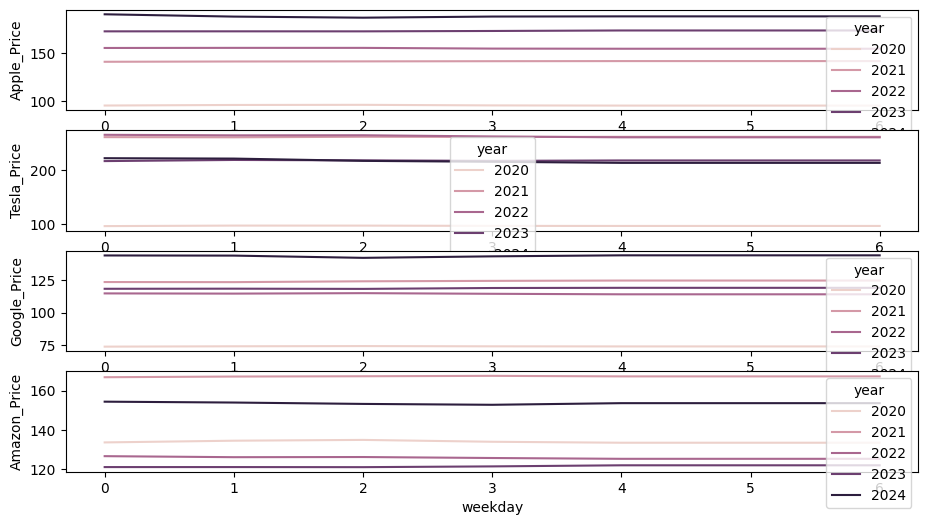

In [38]:
from matplotlib.ticker import FixedLocator, MaxNLocator

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(11, 6))

sns.lineplot(x='weekday',y='Apple_Price',hue='year',data=AW, ax=ax0)
sns.lineplot(x='weekday',y='Tesla_Price',hue='year',data=TW, ax=ax1)
sns.lineplot(x='weekday',y='Google_Price',hue='year',data=GW, ax=ax2)
sns.lineplot(x='weekday',y='Amazon_Price',hue='year',data=AMW, ax=ax3)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(steps=[1]))
ax.xaxis.set_minor_locator(FixedLocator(range(0,5)))

**From the above chart**
- there would be no outstanding seasonality by the day of the week.
- Apple has incresed year by year

We've looked into the general trend and figured out whether there's a seasonality or not so far.\
Regarding all this information from trend and seasonality, Which stock will be good recommendation?
1. Tesla has so much of fluctuation trend which means it has high volitality. - Tesla out
2. Based on the daily and monthly forecast trend
- Apple daily will be *292.93* 
- Apple monthly will be *287.32*
- Google daily will be *238.69*
- Google monthly will be *231.78*
- Amazon daily will be *211.54*
- Amazon monthly will be *395.95*\
> With conservative forecast, Amazon monthly seems so high than daily forecast. Comparing Google and Apple, Apple is better in price, so let's recommend **Apple**

# Forecasting with Prophet Model

Let's forecast the Apple Stock Price with Prophet model for better analysis.

In [39]:
#Data Preparation
Apple_stock = Data_stock[['Date','Apple_Price']]
Apple_stock

,Date,Apple_Price
0,2020-01-02,75.09
1,2020-01-03,74.36
2,2020-01-04,74.36
3,2020-01-05,74.36
4,2020-01-06,74.95
...,...,...
1486,2024-01-27,192.42
1487,2024-01-28,192.42
1488,2024-01-29,191.73
1489,2024-01-30,188.04


In [40]:
#install prophet
%pip install prophet
from prophet import Prophet

Note: you may need to restart the kernel to use updated packages.


In [41]:
#Data preparation
Apple_stock = Apple_stock.rename(columns = {"Date": "ds", "Apple_Price": "y"})
Apple_stock

,ds,y
0,2020-01-02,75.09
1,2020-01-03,74.36
2,2020-01-04,74.36
3,2020-01-05,74.36
4,2020-01-06,74.95
...,...,...
1486,2024-01-27,192.42
1487,2024-01-28,192.42
1488,2024-01-29,191.73
1489,2024-01-30,188.04


### Forecast 365 days later with basic Prophet model

05:21:32 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(83.34722222222221, 0.5, 'Price')

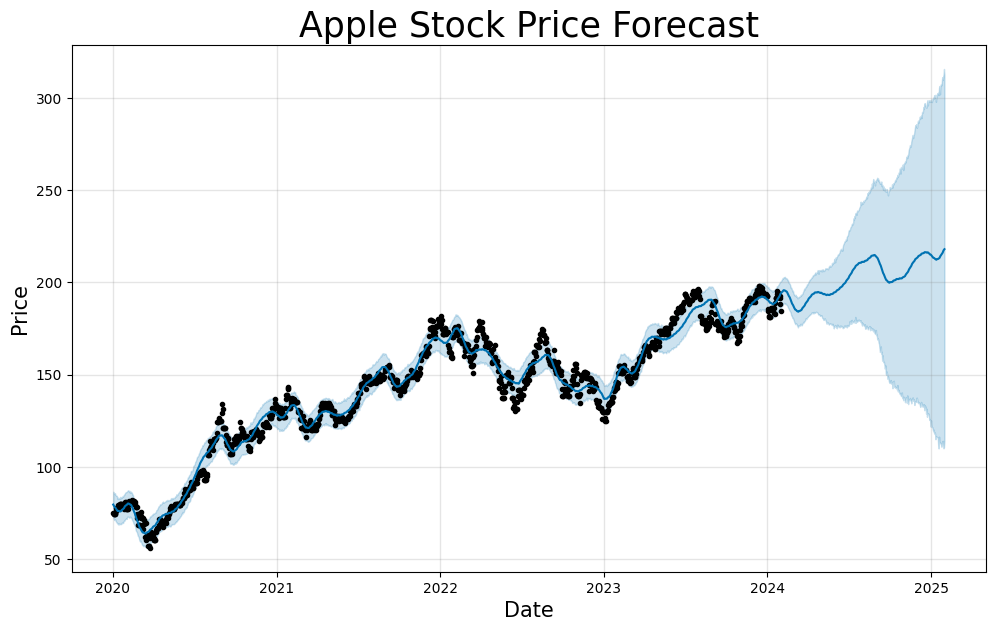

In [42]:
#set model and train it
m = Prophet()
m.fit(Apple_stock)

#dataframe for the forecast(with 365 days)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

#plot the graph with the forecast data
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_title("Apple Stock Price Forecast", size=25)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Price", size=15)

The graph above shows it'll increase as well.

But we need to evaluate this model for more exacte forcasting

In [43]:
Apple_stock.iloc[1125]

ds    2023-01-31 00:00:00
y                  144.29
Name: 1125, dtype: object

In [44]:
Apple_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1491 non-null   datetime64[ns]
 1   y       1491 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB


### Evaluate the basic Prophet model

In [45]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

#cross-validation
#with the first 1125 days and 180 days period, let's forcast 365days
df_cv = cross_validation(m, initial='1125 days', period='180 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)
df_metrics

  0%|          | 0/1 [00:00<?, ?it/s]

05:21:35 - cmdstanpy - INFO - Chain [1] start processing
05:21:35 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,643.204581,25.361478,24.364739,0.161504,0.159460,0.177113,0.0
1,37 days,679.774814,26.072492,25.153240,0.166682,0.162150,0.183212,0.0
2,38 days,709.198329,26.630778,25.735792,0.170647,0.164344,0.187952,0.0
3,39 days,735.820828,27.126018,26.222014,0.174057,0.166687,0.192083,0.0
4,40 days,762.924883,27.621095,26.712086,0.177493,0.169935,0.196255,0.0
...,...,...,...,...,...,...,...,...
325,361 days,9309.693734,96.486754,96.379576,0.509660,0.508371,0.684159,0.0
326,362 days,9327.638597,96.579701,96.469457,0.510214,0.508471,0.685166,0.0
327,363 days,9339.051840,96.638770,96.526818,0.510651,0.508620,0.685960,0.0
328,364 days,9328.923831,96.586354,96.474876,0.510792,0.509481,0.686215,0.0


In [46]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 71.19
Mean Squared Error: 5553.45
Root Mean Squared Error: 74.52


The result doesn't seem to be good. Need to get the best hyperparameter for this model.

# Hyperparameter tuning

In [47]:
# Define the hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
}


# Helper function to evaluate the model
def evaluate_model(model, metric_func):
    df_cv = cross_validation(model, initial='1125 days', period='180 days', horizon='365 days')
    return metric_func(df_cv['y'], df_cv['yhat'])


# Grid search
best_params = {}
best_score = float('inf')

for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, changepoint_prior_scale=cps, seasonality_prior_scale=sps)
            model.fit(Apple_stock)

            # Evaluate the model using Mean Absolute Error (MAE)
            score = evaluate_model(model, mean_absolute_error)

            # Update best parameters if necessary
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

print(best_params)
print(best_score)

05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:38 - cmdstanpy - INFO - Chain [1] done processing
05:21:38 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:39 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:40 - cmdstanpy - INFO - Chain [1] start processing
05:21:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:40 - cmdstanpy - INFO - Chain [1] start processing
05:21:40 - cmdstanpy - INFO - Chain [1] done processing
05:21:41 - cmdstanpy - INFO - Chain [1] start processing
05:21:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:42 - cmdstanpy - INFO - Chain [1] start processing
05:21:42 - cmdstanpy - INFO - Chain [1] done processing
05:21:43 - cmdstanpy - INFO - Chain [1] start processing
05:21:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:45 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1] done processing
05:21:50 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:52 - cmdstanpy - INFO - Chain [1] start processing
05:21:52 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:56 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:05 - cmdstanpy - INFO - Chain [1] start processing
05:22:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:06 - cmdstanpy - INFO - Chain [1] start processing
05:22:08 - cmdstanpy - INFO - Chain [1] done processing
05:22:09 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:11 - cmdstanpy - INFO - Chain [1] done processing
05:22:12 - cmdstanpy - INFO - Chain [1] start processing
05:22:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:14 - cmdstanpy - INFO - Chain [1] start processing
05:22:16 - cmdstanpy - INFO - Chain [1] done processing
05:22:17 - cmdstanpy - INFO - Chain [1] start processing
05:22:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:19 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:23 - cmdstanpy - INFO - Chain [1] start processing
05:22:25 - cmdstanpy - INFO - Chain [1] done processing
05:22:26 - cmdstanpy - INFO - Chain [1] start processing
05:22:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:28 - cmdstanpy - INFO - Chain [1] start processing
05:22:29 - cmdstanpy - INFO - Chain [1] done processing
05:22:30 - cmdstanpy - INFO - Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:31 - cmdstanpy - INFO - Chain [1] start processing
05:22:31 - cmdstanpy - INFO - Chain [1] done processing
05:22:32 - cmdstanpy - INFO - Chain [1] start processing
05:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:32 - cmdstanpy - INFO - Chain [1] start processing
05:22:32 - cmdstanpy - INFO - Chain [1] done processing
05:22:33 - cmdstanpy - INFO - Chain [1] start processing
05:22:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:34 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:35 - cmdstanpy - INFO - Chain [1] start processing
05:22:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:35 - cmdstanpy - INFO - Chain [1] start processing
05:22:36 - cmdstanpy - INFO - Chain [1] done processing
05:22:36 - cmdstanpy - INFO - Chain [1] start processing
05:22:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:38 - cmdstanpy - INFO - Chain [1] start processing
05:22:38 - cmdstanpy - INFO - Chain [1] done processing
05:22:39 - cmdstanpy - INFO - Chain [1] start processing
05:22:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:41 - cmdstanpy - INFO - Chain [1] start processing
05:22:42 - cmdstanpy - INFO - Chain [1] done processing
05:22:43 - cmdstanpy - INFO - Chain [1] start processing
05:22:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:45 - cmdstanpy - INFO - Chain [1] start processing
05:22:46 - cmdstanpy - INFO - Chain [1] done processing
05:22:46 - cmdstanpy - INFO - Chain [1] start processing
05:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:48 - cmdstanpy - INFO - Chain [1] start processing
05:22:49 - cmdstanpy - INFO - Chain [1] done processing
05:22:50 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:53 - cmdstanpy - INFO - Chain [1] done processing
05:22:53 - cmdstanpy - INFO - Chain [1] start processing
05:22:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:55 - cmdstanpy - INFO - Chain [1] start processing
05:22:56 - cmdstanpy - INFO - Chain [1] done processing
05:22:57 - cmdstanpy - INFO - Chain [1] start processing
05:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:22:59 - cmdstanpy - INFO - Chain [1] start processing
05:23:01 - cmdstanpy - INFO - Chain [1] done processing
05:23:01 - cmdstanpy - INFO - Chain [1] start processing
05:23:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:23:03 - cmdstanpy - INFO - Chain [1] start processing
05:23:04 - cmdstanpy - INFO - Chain [1] done processing
05:23:05 - cmdstanpy - INFO - Chain [1] start processing
05:23:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:23:07 - cmdstanpy - INFO - Chain [1] start processing
05:23:09 - cmdstanpy - INFO - Chain [1] done processing
05:23:10 - cmdstanpy - INFO - Chain [1] start processing
05:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:23:11 - cmdstanpy - INFO - Chain [1] start processing
05:23:13 - cmdstanpy - INFO - Chain [1] done processing
05:23:14 - cmdstanpy - INFO - Chain [1] start processing
05:23:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:23:16 - cmdstanpy - INFO - Chain [1] start processing
05:23:18 - cmdstanpy - INFO - Chain [1] done processing
05:23:19 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:22 - cmdstanpy - INFO - Chain [1] done processing


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 10, 'seasonality_prior_scale': 10}
11.452387467794857


# Prophet model with best parameters

05:23:23 - cmdstanpy - INFO - Chain [1] start processing
05:23:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(71.84722222222221, 0.5, 'Price')

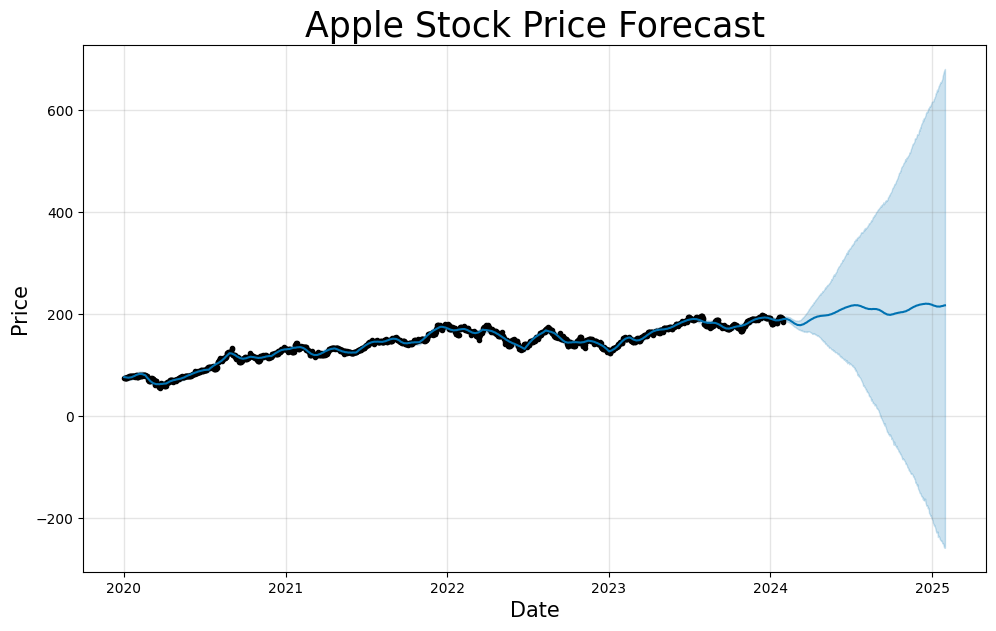

In [48]:
#Model with best parameters
m_best = Prophet(seasonality_mode= 'additive', changepoint_prior_scale = 10, seasonality_prior_scale = 10)
m_best.fit(Apple_stock)

#dataframe for the forecast(with 365 days)
future_best = m_best.make_future_dataframe(periods=365)
forecast_best = m_best.predict(future_best)

#plot the graph with the forecast data
fig1 = m.plot(forecast_best)
ax = fig1.gca()
ax.set_title("Apple Stock Price Forecast", size=25)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Price", size=15)

The adjusted Prophet model also shows the increasing trend. But it's more conservative then the forecasting in the basic model.

### Evaluate the Prophet with best parameters

In [49]:
# Perform cross-validation
df_cv = cross_validation(m_best, initial='1125 days', period='180 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

  0%|          | 0/1 [00:00<?, ?it/s]

05:23:27 - cmdstanpy - INFO - Chain [1] start processing
05:23:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 11.45
Mean Squared Error: 198.28
Root Mean Squared Error: 14.08


We can see the model improved better with the best hyperparameter.

In [50]:
forecast_best

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,74.628829,72.420342,81.442169,74.628829,74.628829,2.274997,2.274997,2.274997,-0.029219,-0.029219,-0.029219,2.304216,2.304216,2.304216,0.0,0.0,0.0,76.903827
1,2020-01-03,74.890583,71.911526,81.029845,74.890583,74.890583,1.874381,1.874381,1.874381,-0.028626,-0.028626,-0.028626,1.903007,1.903007,1.903007,0.0,0.0,0.0,76.764964
2,2020-01-04,75.152337,72.189738,80.933495,75.152337,75.152337,1.402455,1.402455,1.402455,-0.095038,-0.095038,-0.095038,1.497493,1.497493,1.497493,0.0,0.0,0.0,76.554792
3,2020-01-05,75.414091,71.167641,81.101821,75.414091,75.414091,0.919425,0.919425,0.919425,-0.173095,-0.173095,-0.173095,1.092520,1.092520,1.092520,0.0,0.0,0.0,76.333515
4,2020-01-06,75.675845,71.704490,81.138074,75.675845,75.675845,0.747583,0.747583,0.747583,0.054510,0.054510,0.054510,0.693074,0.693074,0.693074,0.0,0.0,0.0,76.423428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,2025-01-26,218.012604,-248.995478,670.657840,-250.305001,673.538219,-1.336611,-1.336611,-1.336611,-0.173095,-0.173095,-0.173095,-1.163516,-1.163516,-1.163516,0.0,0.0,0.0,216.675993
1852,2025-01-27,218.086697,-253.442277,674.569858,-252.836847,675.241736,-0.944227,-0.944227,-0.944227,0.054510,0.054510,0.054510,-0.998737,-0.998737,-0.998737,0.0,0.0,0.0,217.142470
1853,2025-01-28,218.160790,-257.038562,677.438435,-255.055290,676.885274,-0.683387,-0.683387,-0.683387,0.160860,0.160860,0.160860,-0.844248,-0.844248,-0.844248,0.0,0.0,0.0,217.477403
1854,2025-01-29,218.234883,-255.581159,678.790372,-257.209845,678.528812,-0.595897,-0.595897,-0.595897,0.110607,0.110607,0.110607,-0.706504,-0.706504,-0.706504,0.0,0.0,0.0,217.638986


With the Prophet model with the best parameters, We can assume that the stock price of Apple will be around **$218** after 1 year.

# Conclusion

The lastest price of Apple in the given dataset is **184.4 USD**\
The Price in the daily trend is **292.9 USD**\
The Price in the monthly trend is **287.32 USD**\
The Price in the Prophet model is **218 USD**

Regarding whole this analysis, We can recommend to the client that buy a Apple stock which has a possibility to increase at the pric of 218 USD. It is more proficient and unvolatile than other options like Amazon, Tesla, Google.